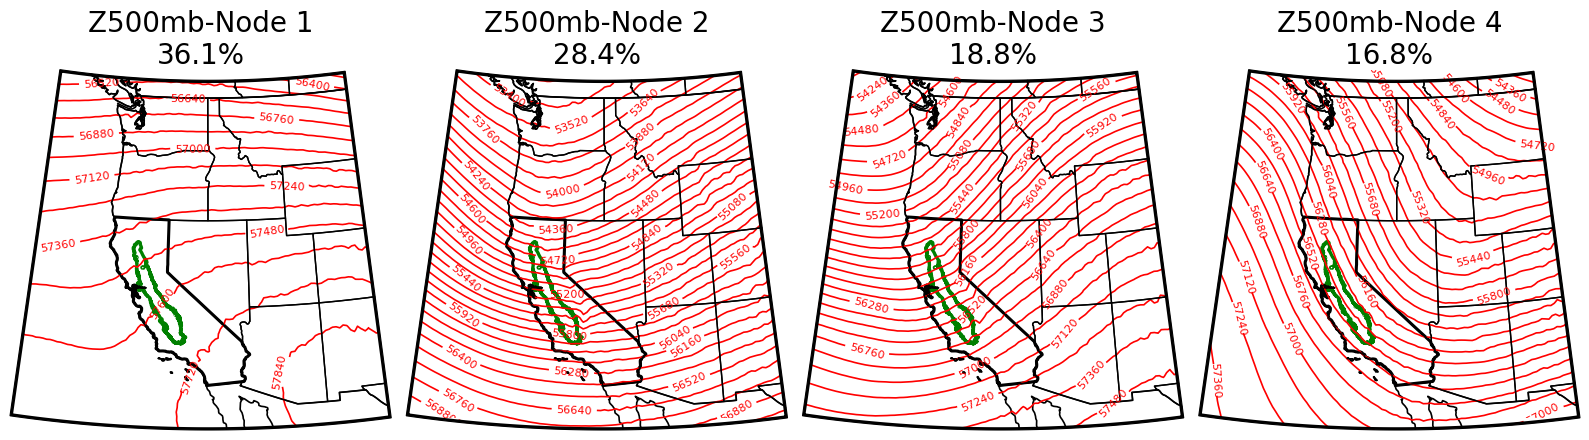

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu

# ---------------------- curved “box” boundary (unchanged) ----------------------
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
box_path = Path(pts, codes)

def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# ------------------------------ CV shapefiles ---------------------------------
cv_gdf  = gpd.read_file("central_valley_alluvial_boundary_usgs.shp").to_crs(epsg=4326)
cv1_gdf = gpd.read_file("california_shapefile.shp").to_crs(epsg=4326)

# --------------------------- load geopotential z500 ----------------------------
ds = xr.open_dataset("z_dust.nc")

# try common names
time_name = "date" if "date" in ds.coords or "date" in ds.dims else \
            "time" if "time" in ds.coords or "time" in ds.dims else None
if time_name is None:
    raise KeyError("No time coordinate named 'date' or 'time' found.")

# variable name: 'gh' assumed; change here if yours differs
z = ds["z"]
# select 500 hPa if pressure_level is present
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

# ----------------------------- subset SON season -------------------------------
ason = z.sel({time_name: ds[time_name].dt.month.isin([8,9,10,11])})
ason = (
    ason
    .where((ason.latitude >= lat0) & (ason.latitude <= lat1), drop=True)
    .where((ason.longitude >= lon0) & (ason.longitude <= lon1), drop=True)
)

# ---------------------------- flatten & train SOM ------------------------------
data = ason.values               # (ntime, nlat, nlon)
ntime, nlat, nlon = data.shape
flat  = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

# ------------------------- composites & frequencies ----------------------------
# Somoclu BMUs are (row, col). Convert to a single node index 0..3.
labels = som.bmus[:,0] * 2 + som.bmus[:,1]

comps, freqs = {}, {}
for node in range(4):
    mask = (labels == node)
    freqs[node] = mask.sum() / ntime * 100.0
    comps[node] = np.nanmean(data[mask], axis=0) if mask.any() else np.full((nlat, nlon), np.nan)

# ------------------------------- contour levels --------------------------------
vmin = min(np.nanmin(c) for c in comps.values())
vmax = max(np.nanmax(c) for c in comps.values())
levels = np.arange((vmin//120)*120, (vmax//120+1)*120 + 1, 120)

# ---------------------------- grids & projection --------------------------------
lon2d, lat2d = np.meshgrid(ason.longitude, ason.latitude)
proj = ccrs.LambertConformal(central_longitude=-117, central_latitude=35,
                             standard_parallels=(33, 45))

# ------------------- ORDER NODES BY FREQUENCY (DESCENDING) ---------------------
sorted_nodes = sorted(freqs.keys(), key=lambda n: freqs[n], reverse=True)
# After this, rank=1 is the most frequent, rank=4 is the least frequent.

# ------------------------------- plotting --------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(16, 6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0, 0, 1, 0.88])

for rank, node in enumerate(sorted_nodes, start=1):
    ax = axes[rank-1]
    clip_to_curve(ax)
    ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

    cs = ax.contour(lon2d, lat2d, comps[node], levels=levels,
                    colors="red", linewidths=1.2, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%d", fontsize=8)

    ax.add_geometries(cv_gdf.geometry,  crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=2.4)
    ax.add_geometries(cv1_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="black", facecolor="none", linewidth=2.2)

    ax.coastlines(resolution="50m", linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linewidth=1.2)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=1, zorder=2)

    # Title: Node rank by frequency + its percentage
    ax.set_title(f"Z500mb-Node {rank}\n{freqs[node]:.1f}%", fontsize=20, pad=4)

fig.suptitle("", fontsize=20)
fig.savefig("SON2_combined_ASON.png", dpi=500, bbox_inches="tight")
plt.show()


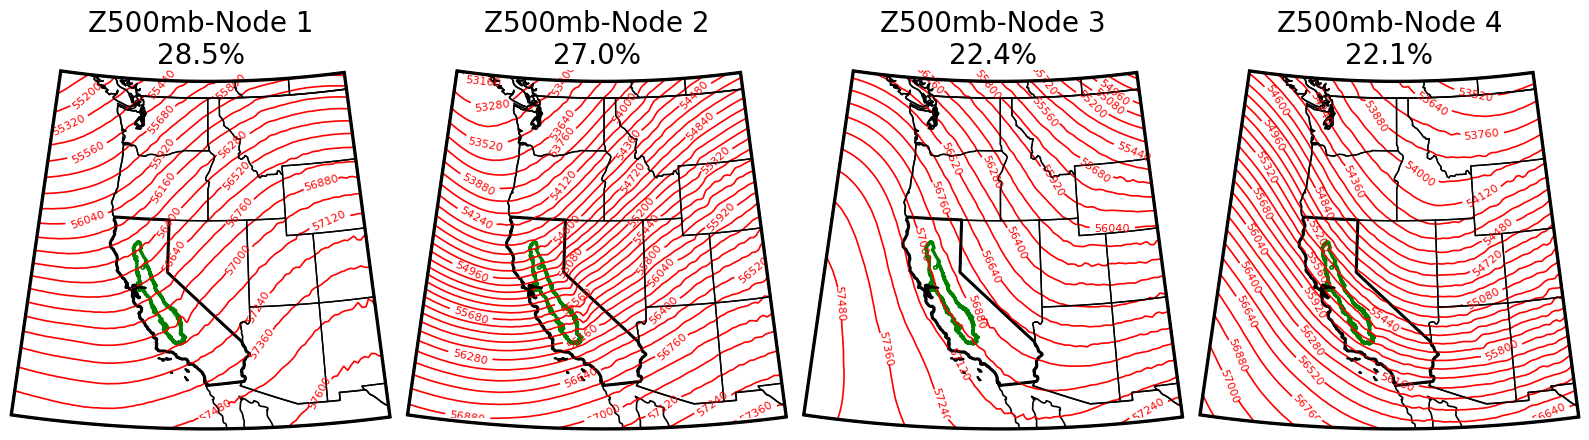

In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu

# ---------------------- curved “box” boundary (unchanged) ----------------------
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
box_path = Path(pts, codes)

def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# ------------------------------ CV shapefiles ---------------------------------
cv_gdf  = gpd.read_file("central_valley_alluvial_boundary_usgs.shp").to_crs(epsg=4326)
cv1_gdf = gpd.read_file("california_shapefile.shp").to_crs(epsg=4326)

# --------------------------- load geopotential z500 ----------------------------
ds = xr.open_dataset("z_dust.nc")

# try common names
time_name = "date" if "date" in ds.coords or "date" in ds.dims else \
            "time" if "time" in ds.coords or "time" in ds.dims else None
if time_name is None:
    raise KeyError("No time coordinate named 'date' or 'time' found.")

# variable name: 'gh' assumed; change here if yours differs
z = ds["z"]
# select 500 hPa if pressure_level is present
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

# ----------------------------- subset SON season -------------------------------
ason = z.sel({time_name: ds[time_name].dt.month.isin([9,10,11])})
ason = (
    ason
    .where((ason.latitude >= lat0) & (ason.latitude <= lat1), drop=True)
    .where((ason.longitude >= lon0) & (ason.longitude <= lon1), drop=True)
)

# ---------------------------- flatten & train SOM ------------------------------
data = ason.values               # (ntime, nlat, nlon)
ntime, nlat, nlon = data.shape
flat  = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

# ------------------------- composites & frequencies ----------------------------
# Somoclu BMUs are (row, col). Convert to a single node index 0..3.
labels = som.bmus[:,0] * 2 + som.bmus[:,1]

comps, freqs = {}, {}
for node in range(4):
    mask = (labels == node)
    freqs[node] = mask.sum() / ntime * 100.0
    comps[node] = np.nanmean(data[mask], axis=0) if mask.any() else np.full((nlat, nlon), np.nan)

# ------------------------------- contour levels --------------------------------
vmin = min(np.nanmin(c) for c in comps.values())
vmax = max(np.nanmax(c) for c in comps.values())
levels = np.arange((vmin//120)*120, (vmax//120+1)*120 + 1, 120)

# ---------------------------- grids & projection --------------------------------
lon2d, lat2d = np.meshgrid(ason.longitude, ason.latitude)
proj = ccrs.LambertConformal(central_longitude=-117, central_latitude=35,
                             standard_parallels=(33, 45))

# ------------------- ORDER NODES BY FREQUENCY (DESCENDING) ---------------------
sorted_nodes = sorted(freqs.keys(), key=lambda n: freqs[n], reverse=True)
# After this, rank=1 is the most frequent, rank=4 is the least frequent.

# ------------------------------- plotting --------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(16, 6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0, 0, 1, 0.88])

for rank, node in enumerate(sorted_nodes, start=1):
    ax = axes[rank-1]
    clip_to_curve(ax)
    ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

    cs = ax.contour(lon2d, lat2d, comps[node], levels=levels,
                    colors="red", linewidths=1.2, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%d", fontsize=8)

    ax.add_geometries(cv_gdf.geometry,  crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=2.4)
    ax.add_geometries(cv1_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="black", facecolor="none", linewidth=2.2)

    ax.coastlines(resolution="50m", linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linewidth=1.2)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=1, zorder=2)

    # Title: Node rank by frequency + its percentage
    ax.set_title(f"Z500mb-Node {rank}\n{freqs[node]:.1f}%", fontsize=20, pad=4)



fig.suptitle("", fontsize=20)
fig.savefig("SON.png", dpi=500, bbox_inches="tight")
plt.show()


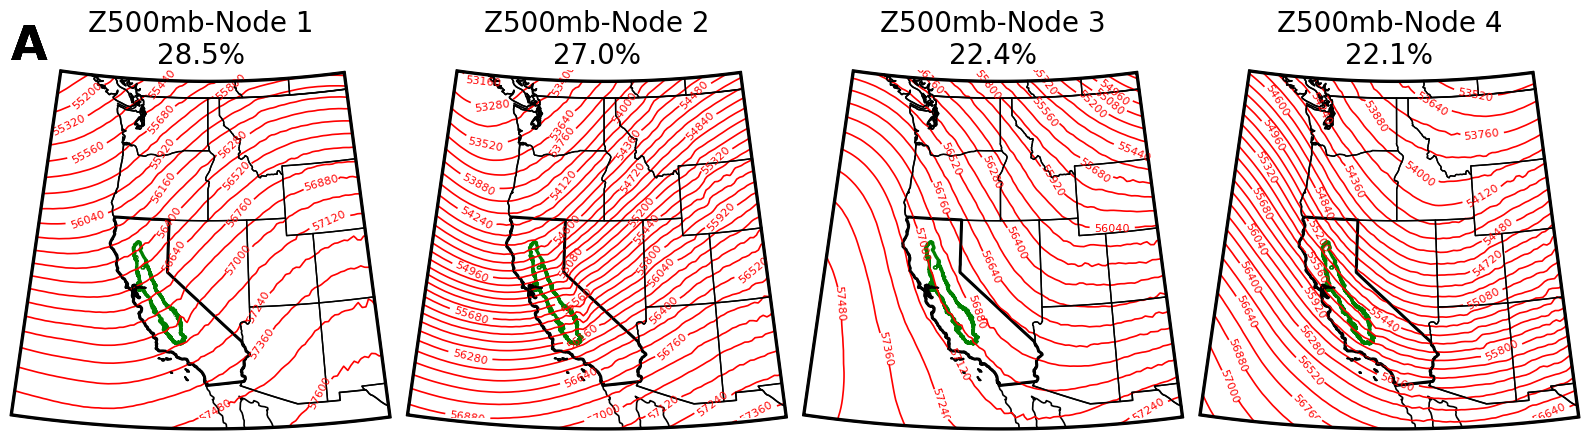

In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu

# ---------------------- curved “box” boundary (unchanged) ----------------------
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
box_path = Path(pts, codes)

def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# ------------------------------ CV shapefiles ---------------------------------
cv_gdf  = gpd.read_file("central_valley_alluvial_boundary_usgs.shp").to_crs(epsg=4326)
cv1_gdf = gpd.read_file("california_shapefile.shp").to_crs(epsg=4326)

# --------------------------- load geopotential z500 ----------------------------
ds = xr.open_dataset("z_dust.nc")

# try common names
time_name = "date" if "date" in ds.coords or "date" in ds.dims else \
            "time" if "time" in ds.coords or "time" in ds.dims else None
if time_name is None:
    raise KeyError("No time coordinate named 'date' or 'time' found.")

# variable name: 'gh' assumed; change here if yours differs
z = ds["z"]
# select 500 hPa if pressure_level is present
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

# ----------------------------- subset SON season -------------------------------
ason = z.sel({time_name: ds[time_name].dt.month.isin([9,10,11])})
ason = (
    ason
    .where((ason.latitude >= lat0) & (ason.latitude <= lat1), drop=True)
    .where((ason.longitude >= lon0) & (ason.longitude <= lon1), drop=True)
)

# ---------------------------- flatten & train SOM ------------------------------
data = ason.values               # (ntime, nlat, nlon)
ntime, nlat, nlon = data.shape
flat  = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(777)
som.train(flat, epochs=1000)

# ------------------------- composites & frequencies ----------------------------
# Somoclu BMUs are (row, col). Convert to a single node index 0..3.
labels = som.bmus[:,0] * 2 + som.bmus[:,1]

comps, freqs = {}, {}
for node in range(4):
    mask = (labels == node)
    freqs[node] = mask.sum() / ntime * 100.0
    comps[node] = np.nanmean(data[mask], axis=0) if mask.any() else np.full((nlat, nlon), np.nan)

# ------------------------------- contour levels --------------------------------
vmin = min(np.nanmin(c) for c in comps.values())
vmax = max(np.nanmax(c) for c in comps.values())
levels = np.arange((vmin//120)*120, (vmax//120+1)*120 + 1, 120)

# ---------------------------- grids & projection --------------------------------
lon2d, lat2d = np.meshgrid(ason.longitude, ason.latitude)
proj = ccrs.LambertConformal(central_longitude=-117, central_latitude=35,
                             standard_parallels=(33, 45))

# ------------------- ORDER NODES BY FREQUENCY (DESCENDING) ---------------------
sorted_nodes = sorted(freqs.keys(), key=lambda n: freqs[n], reverse=True)
# After this, rank=1 is the most frequent, rank=4 is the least frequent.

# ------------------------------- plotting --------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(16, 6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0, 0, 1, 0.88])

for rank, node in enumerate(sorted_nodes, start=1):
    ax = axes[rank-1]
    clip_to_curve(ax)
    ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

    cs = ax.contour(lon2d, lat2d, comps[node], levels=levels,
                    colors="red", linewidths=1.2, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%d", fontsize=8)

    ax.add_geometries(cv_gdf.geometry,  crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=2.4)
    ax.add_geometries(cv1_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="black", facecolor="none", linewidth=2.2)

    ax.coastlines(resolution="50m", linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linewidth=1.2)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=1, zorder=2)

    # Title: Node rank by frequency + its percentage
    ax.set_title(f"Z500mb-Node {rank}\n{freqs[node]:.1f}%", fontsize=20, pad=4)
    
    ax0=axes.flat[0]
    
    b = ax0.get_position()
    fig.text(0.01, b.y1,"A", ha="left",va="bottom", fontsize=34,fontweight="bold",
             fontfamily="sans-serif",transform=fig.transFigure)

fig.suptitle("", fontsize=20)
fig.savefig("SON8.png", dpi=500, bbox_inches="tight")
plt.show()


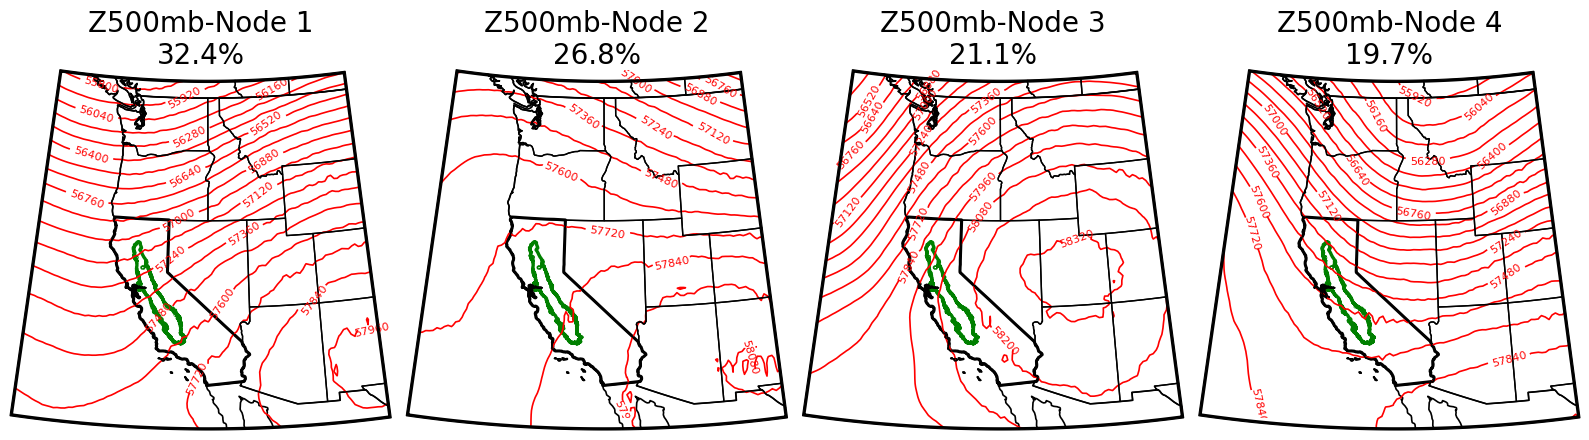

In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu

# ---------------------- curved “box” boundary (unchanged) ----------------------
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
box_path = Path(pts, codes)

def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# ------------------------------ CV shapefiles ---------------------------------
cv_gdf  = gpd.read_file("central_valley_alluvial_boundary_usgs.shp").to_crs(epsg=4326)
cv1_gdf = gpd.read_file("california_shapefile.shp").to_crs(epsg=4326)

# --------------------------- load geopotential z500 ----------------------------
ds = xr.open_dataset("z_dust.nc")

# try common names
time_name = "date" if "date" in ds.coords or "date" in ds.dims else \
            "time" if "time" in ds.coords or "time" in ds.dims else None
if time_name is None:
    raise KeyError("No time coordinate named 'date' or 'time' found.")

# variable name: 'gh' assumed; change here if yours differs
z = ds["z"]
# select 500 hPa if pressure_level is present
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

# ----------------------------- subset SON season -------------------------------
ason = z.sel({time_name: ds[time_name].dt.month.isin([8])})
ason = (
    ason
    .where((ason.latitude >= lat0) & (ason.latitude <= lat1), drop=True)
    .where((ason.longitude >= lon0) & (ason.longitude <= lon1), drop=True)
)

# ---------------------------- flatten & train SOM ------------------------------
data = ason.values               # (ntime, nlat, nlon)
ntime, nlat, nlon = data.shape
flat  = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

# ------------------------- composites & frequencies ----------------------------
# Somoclu BMUs are (row, col). Convert to a single node index 0..3.
labels = som.bmus[:,0] * 2 + som.bmus[:,1]

comps, freqs = {}, {}
for node in range(4):
    mask = (labels == node)
    freqs[node] = mask.sum() / ntime * 100.0
    comps[node] = np.nanmean(data[mask], axis=0) if mask.any() else np.full((nlat, nlon), np.nan)

# ------------------------------- contour levels --------------------------------
vmin = min(np.nanmin(c) for c in comps.values())
vmax = max(np.nanmax(c) for c in comps.values())
levels = np.arange((vmin//120)*120, (vmax//120+1)*120 + 1, 120)

# ---------------------------- grids & projection --------------------------------
lon2d, lat2d = np.meshgrid(ason.longitude, ason.latitude)
proj = ccrs.LambertConformal(central_longitude=-117, central_latitude=35,
                             standard_parallels=(33, 45))

# ------------------- ORDER NODES BY FREQUENCY (DESCENDING) ---------------------
sorted_nodes = sorted(freqs.keys(), key=lambda n: freqs[n], reverse=True)
# After this, rank=1 is the most frequent, rank=4 is the least frequent.

# ------------------------------- plotting --------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(16, 6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0, 0, 1, 0.88])

for rank, node in enumerate(sorted_nodes, start=1):
    ax = axes[rank-1]
    clip_to_curve(ax)
    ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

    cs = ax.contour(lon2d, lat2d, comps[node], levels=levels,
                    colors="red", linewidths=1.2, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%d", fontsize=8)

    ax.add_geometries(cv_gdf.geometry,  crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=2.4)
    ax.add_geometries(cv1_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="black", facecolor="none", linewidth=2.2)

    ax.coastlines(resolution="50m", linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linewidth=1.2)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=1, zorder=2)

    # Title: Node rank by frequency + its percentage
    ax.set_title(f"Z500mb-Node {rank}\n{freqs[node]:.1f}%", fontsize=20, pad=4)

fig.suptitle("", fontsize=20)
fig.savefig("AUG.png", dpi=500, bbox_inches="tight")
plt.show()


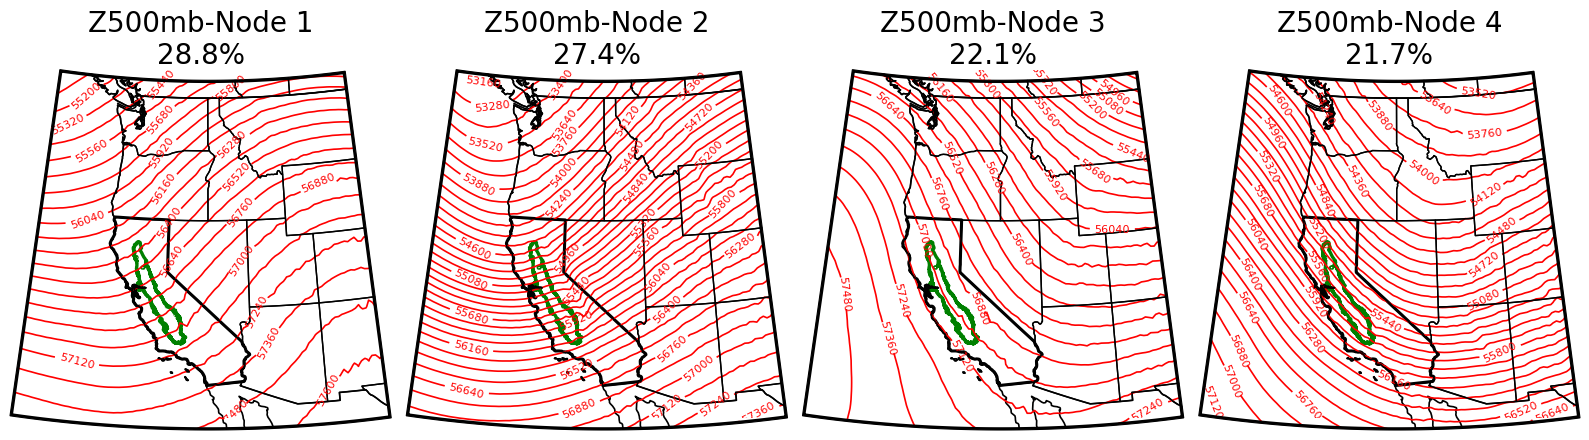

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu

# ---------------------- curved “box” boundary (unchanged) ----------------------
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
box_path = Path(pts, codes)

def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# ------------------------------ CV shapefiles ---------------------------------
cv_gdf  = gpd.read_file("central_valley_alluvial_boundary_usgs.shp").to_crs(epsg=4326)
cv1_gdf = gpd.read_file("california_shapefile.shp").to_crs(epsg=4326)

# --------------------------- load geopotential z500 ----------------------------
ds = xr.open_dataset("z_dust.nc")

# try common names
time_name = "date" if "date" in ds.coords or "date" in ds.dims else \
            "time" if "time" in ds.coords or "time" in ds.dims else None
if time_name is None:
    raise KeyError("No time coordinate named 'date' or 'time' found.")

# variable name: 'gh' assumed; change here if yours differs
z = ds["z"]
# select 500 hPa if pressure_level is present
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

# ----------------------------- subset SON season -------------------------------
ason = z.sel({time_name: ds[time_name].dt.month.isin([9,10,11])})
ason = (
    ason
    .where((ason.latitude >= lat0) & (ason.latitude <= lat1), drop=True)
    .where((ason.longitude >= lon0) & (ason.longitude <= lon1), drop=True)
)

# ---------------------------- flatten & train SOM ------------------------------
data = ason.values               # (ntime, nlat, nlon)
ntime, nlat, nlon = data.shape
flat  = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

# ------------------------- composites & frequencies ----------------------------
# Somoclu BMUs are (row, col). Convert to a single node index 0..3.
labels = som.bmus[:,0] * 2 + som.bmus[:,1]

comps, freqs = {}, {}
for node in range(4):
    mask = (labels == node)
    freqs[node] = mask.sum() / ntime * 100.0
    comps[node] = np.nanmean(data[mask], axis=0) if mask.any() else np.full((nlat, nlon), np.nan)

# ------------------------------- contour levels --------------------------------
vmin = min(np.nanmin(c) for c in comps.values())
vmax = max(np.nanmax(c) for c in comps.values())
levels = np.arange((vmin//120)*120, (vmax//120+1)*120 + 1, 120)

# ---------------------------- grids & projection --------------------------------
lon2d, lat2d = np.meshgrid(ason.longitude, ason.latitude)
proj = ccrs.LambertConformal(central_longitude=-117, central_latitude=35,
                             standard_parallels=(33, 45))

# ------------------- ORDER NODES BY FREQUENCY (DESCENDING) ---------------------
sorted_nodes = sorted(freqs.keys(), key=lambda n: freqs[n], reverse=True)
# After this, rank=1 is the most frequent, rank=4 is the least frequent.

# ------------------------------- plotting --------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(16, 6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0, 0, 1, 0.88])

for rank, node in enumerate(sorted_nodes, start=1):
    ax = axes[rank-1]
    clip_to_curve(ax)
    ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

    cs = ax.contour(lon2d, lat2d, comps[node], levels=levels,
                    colors="red", linewidths=1.2, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%d", fontsize=8)

    ax.add_geometries(cv_gdf.geometry,  crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=2.4)
    ax.add_geometries(cv1_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="black", facecolor="none", linewidth=2.2)

    ax.coastlines(resolution="50m", linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linewidth=1.2)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=1, zorder=2)

    # Title: Node rank by frequency + its percentage
    ax.set_title(f"Z500mb-Node {rank}\n{freqs[node]:.1f}%", fontsize=20, pad=4)

fig.suptitle("", fontsize=20)
fig.savefig("SON.png", dpi=500, bbox_inches="tight")
plt.show()


/home/precious/anaconda3/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfradial1' loading failed:
cannot import name 'DataTree' from 'xarray' (/home/precious/anaconda3/lib/python3.11/site-packages/xarray/__init__.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/precious/anaconda3/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'datamet' loading failed:
cannot import name 'DataTree' from 'xarray' (/home/precious/anaconda3/lib/python3.11/site-packages/xarray/__init__.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/precious/anaconda3/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'furuno' loading failed:
cannot import name 'DataTree' from 'xarray' (/home/precious/anaconda3/lib/python3.11/site-packages/xarray/__init__.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/precious/ana

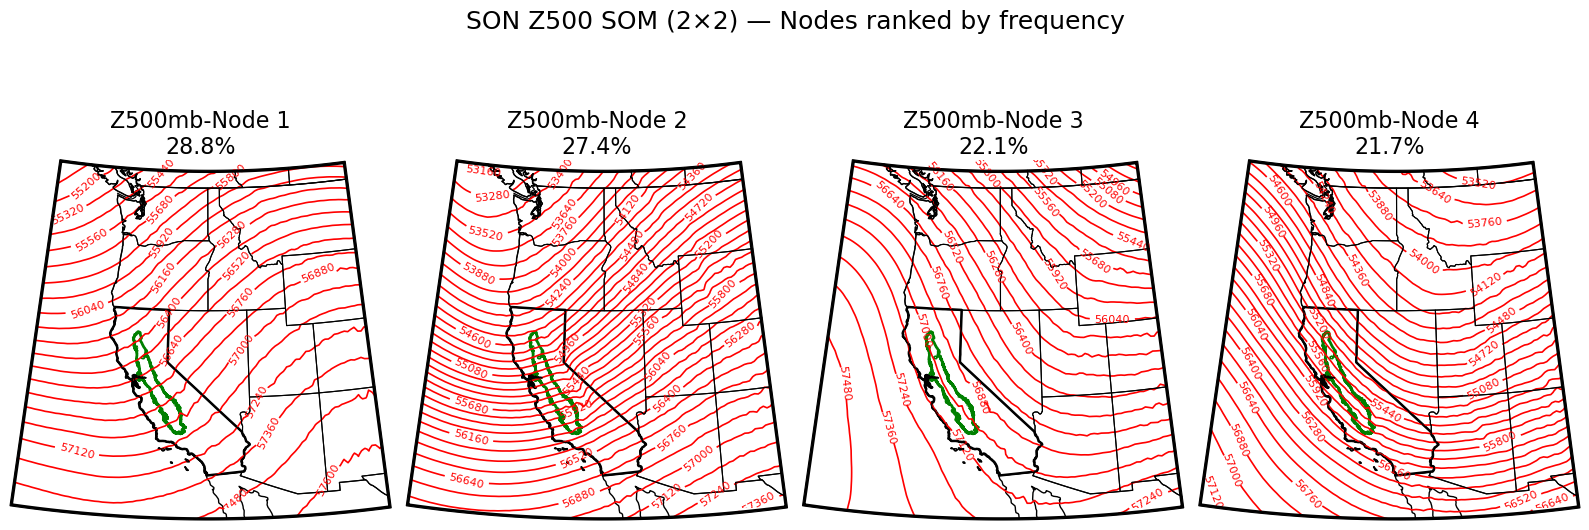

Node 1: 81 dates
Node 2: 77 dates
Node 3: 62 dates
Node 4: 61 dates

Node 1 (first 10): ['2005-09-21', '2005-09-26', '2005-10-14', '2005-10-15', '2005-10-18', '2005-11-10', '2006-10-01', '2007-09-20', '2007-10-10', '2007-10-30']
Node 1 (last 10):  ['2023-09-03', '2023-09-11', '2023-09-15', '2023-09-16', '2023-09-17', '2023-10-01', '2023-10-09', '2023-10-10', '2023-10-22', '2024-09-16']

Node 2 (first 10): ['2005-10-03', '2005-10-04', '2005-11-02', '2005-11-03', '2006-09-14', '2006-09-15', '2006-11-02', '2006-11-03', '2006-11-08', '2007-10-15']
Node 2 (last 10):  ['2023-10-23', '2023-10-25', '2023-10-26', '2023-11-13', '2023-11-15', '2023-11-16', '2024-10-28', '2024-11-11', '2024-11-12', '2024-11-13']

Node 3 (first 10): ['2006-09-22', '2006-09-23', '2007-09-05', '2007-09-06', '2008-09-01', '2008-11-14', '2009-10-25', '2010-10-11', '2010-10-12', '2011-09-10']
Node 3 (last 10):  ['2022-09-10', '2022-10-16', '2022-11-16', '2022-11-20', '2023-09-21', '2023-10-04', '2023-10-05', '2023-10-06

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu
from pathlib import Path as PPath

# ---------------------- domain & curved boundary ----------------------
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
box_path = MplPath(pts, codes)

def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def pick_coord(ds, cand):
    for c in cand:
        if c in ds.coords or c in ds.dims:
            return c
    raise KeyError(f"None of {cand} found among coords/dims: {list(ds.coords) + list(ds.dims)}")

# ------------------------------ I/O ---------------------------------
Z_NC = "z_dust.nc"                  # adjust if needed
OUT_FIG = "SON_Z500ff_SOM_nodes.png"
CV_SHP  = "central_valley_alluvial_boundary_usgs.shp"
CA_SHP  = "california_shapefile.shp"

# ------------------------ Load shapefiles (optional) ----------------
cv_gdf = None
ca_gdf = None
if PPath(CV_SHP).exists():
    cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
if PPath(CA_SHP).exists():
    ca_gdf = gpd.read_file(CA_SHP).to_crs(epsg=4326)

# --------------------------- Load Z500 ------------------------------
ds = xr.open_dataset(Z_NC)

# time/lat/lon names
time_name = pick_coord(ds, ["time", "date"])

# variable: try typical names
var_candidates = ["z", "gh", "hgt", "Z", "HGT"]
for v in var_candidates:
    if v in ds.data_vars:
        z = ds[v]
        break
else:
    z = list(ds.data_vars.values())[0]

# select 500 hPa if present (accept 500 or 50000)
lev_name = None
for cand in ["pressure_level", "level", "isobaricInhPa", "isobaric"]:
    if cand in z.dims or cand in z.coords:
        lev_name = cand
        break

if lev_name is not None:
    lev_vals = np.asarray(z[lev_name].values).astype(float)
    target = 500.0
    idx = np.where(np.isclose(lev_vals, target))[0]
    if idx.size == 0:
        idx = np.where(np.isclose(lev_vals, target * 100.0))[0]
    if idx.size == 0:
        idx = [np.argmin(np.abs(lev_vals - target))]
    z = z.isel({lev_name: int(idx[0])})

lat_name = pick_coord(z, ["latitude", "lat", "y"])
lon_name = pick_coord(z, ["longitude", "lon", "x"])

# -------------------------- Subset SON & box ------------------------
ason = z.sel({time_name: ds[time_name].dt.month.isin([9, 10, 11])})
ason = (
    ason
    .where((ason[lat_name] >= lat0) & (ason[lat_name] <= lat1), drop=True)
    .where((ason[lon_name] >= lon0) & (ason[lon_name] <= lon1), drop=True)
).transpose(time_name, lat_name, lon_name)

# ---------------------- Clean & prepare for SOM ---------------------
data = ason.values.astype("float32")  # Somoclu prefers float32
ntime, nlat, nlon = data.shape

# Fill NaNs with time-mean at gridpoint; if still NaN, use global mean
if np.isnan(data).any():
    tmean = np.nanmean(data, axis=0)
    if ~np.isfinite(tmean).any():
        raise ValueError("All-NaN field encountered; check input data.")
    bad_tmean = ~np.isfinite(tmean)
    if bad_tmean.any():
        tmean[bad_tmean] = np.nanmean(data[np.isfinite(data)])
    ii = ~np.isfinite(data)
    data[ii] = np.broadcast_to(tmean, data.shape)[ii]

flat = data.reshape(ntime, nlat * nlon)

# ---------------------- Train 2x2 SOM -------------------------------
som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

# BMUs (row, col) -> node 0..3
labels = som.bmus[:, 0] * 2 + som.bmus[:, 1]

# ------------------- Composites & frequencies -----------------------
comps, freqs = {}, {}
for node in range(4):
    mask = (labels == node)
    freqs[node] = float(mask.sum()) / float(ntime) * 100.0
    comps[node] = np.mean(data[mask], axis=0) if mask.any() else np.full((nlat, nlon), np.nan, dtype="float32")

# ----------------------- Contour levels -----------------------------
vmin = np.nanmin([np.nanmin(c) for c in comps.values()])
vmax = np.nanmax([np.nanmax(c) for c in comps.values()])
step = 120.0
start = np.floor(vmin / step) * step
end   = np.ceil(vmax / step) * step
levels = np.arange(start, end + step, step)

# ---------------------- Grid & projection ---------------------------
lon2d, lat2d = np.meshgrid(ason[lon_name].values, ason[lat_name].values)
proj = ccrs.LambertConformal(central_longitude=-117, central_latitude=35,
                             standard_parallels=(33, 45))

# -------- ORDER nodes by frequency (desc) → rank 1..4 ---------------
sorted_nodes = sorted(freqs.keys(), key=lambda n: freqs[n], reverse=True)
node_to_rank = {node: rank for rank, node in enumerate(sorted_nodes, start=1)}

# ----------------------------- Plotting -----------------------------
fig, axes = plt.subplots(1, 4, figsize=(16, 6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0, 0, 1, 0.88])

for rank, node in enumerate(sorted_nodes, start=1):
    ax = axes[rank - 1]
    clip_to_curve(ax)
    ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

    cs = ax.contour(lon2d, lat2d, comps[node], levels=levels,
                    colors="red", linewidths=1.2, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%d", fontsize=8)

    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=2.0)
    if ca_gdf is not None:
        ax.add_geometries(ca_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="black", facecolor="none", linewidth=1.8)

    ax.coastlines(resolution="50m", linewidth=1.0)
    ax.add_feature(cfeature.BORDERS, linewidth=0.9)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.8, zorder=2)

    ax.set_title(f"Z500mb-Node {rank}\n{freqs[node]:.1f}%", fontsize=16, pad=4)

fig.suptitle("SON Z500 SOM (2×2) — Nodes ranked by frequency", fontsize=18)
fig.savefig(OUT_FIG, dpi=500, bbox_inches="tight")
plt.show()

# ===================== SANITY: Event dates per node =====================
t_son = pd.to_datetime(ason[time_name].values)
rank_id = pd.Series(labels).map(node_to_rank).to_numpy()  # 1..4

df_events = pd.DataFrame({
    "date": t_son,
    "node_raw": labels,         # 0..3 raw BMU
    "node_rank": rank_id        # 1..4 (frequency order)
}).sort_values("date").reset_index(drop=True)

# Save master and per-node lists (CSV + TXT)
df_events.to_csv("SON_Z500_SOM_event_dates_all.csv", index=False)

for r in sorted(df_events["node_rank"].unique()):
    sub = df_events.loc[df_events["node_rank"] == r, ["date"]].copy()
    sub.to_csv(f"SON_Z500_SOM_node{r}_dates.csv", index=False)
    sub["date"].dt.strftime("%Y-%m-%d").to_csv(
        f"SON_Z500_SOM_node{r}_dates.txt", index=False, header=False
    )
    print(f"Node {r}: {len(sub)} dates")

# Peek first/last dates for each node
for r in range(1, 5):
    sub = df_events.loc[df_events["node_rank"] == r, "date"].dt.strftime("%Y-%m-%d").tolist()
    print(f"\nNode {r} (first 10): {sub[:10]}")
    print(f"Node {r} (last 10):  {sub[-10:]}")

# Monthly counts (useful sanity check)
monthly = (
    df_events
    .assign(month=lambda d: d["date"].dt.to_period("M"))
    .groupby(["month", "node_rank"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)
monthly.index = monthly.index.astype(str)
monthly.to_csv("SON_Z500_SOM_monthly_counts_by_node.csv")
print("\nMonthly counts by node (SON):")
print(monthly.tail(12))
